**1. Environment**

In [ ]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
from scipy.stats import genextreme as gev

# Import some extra functions from utils folder
import sys
sys.path.insert(1, '/home/philinat') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

! pwd

**2. Geographical coordinates**

In [3]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/MARgrid_EUl.nc')
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi',
                 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

(<matplotlib.lines.Line2D at 0x7fbc1172d190>,)

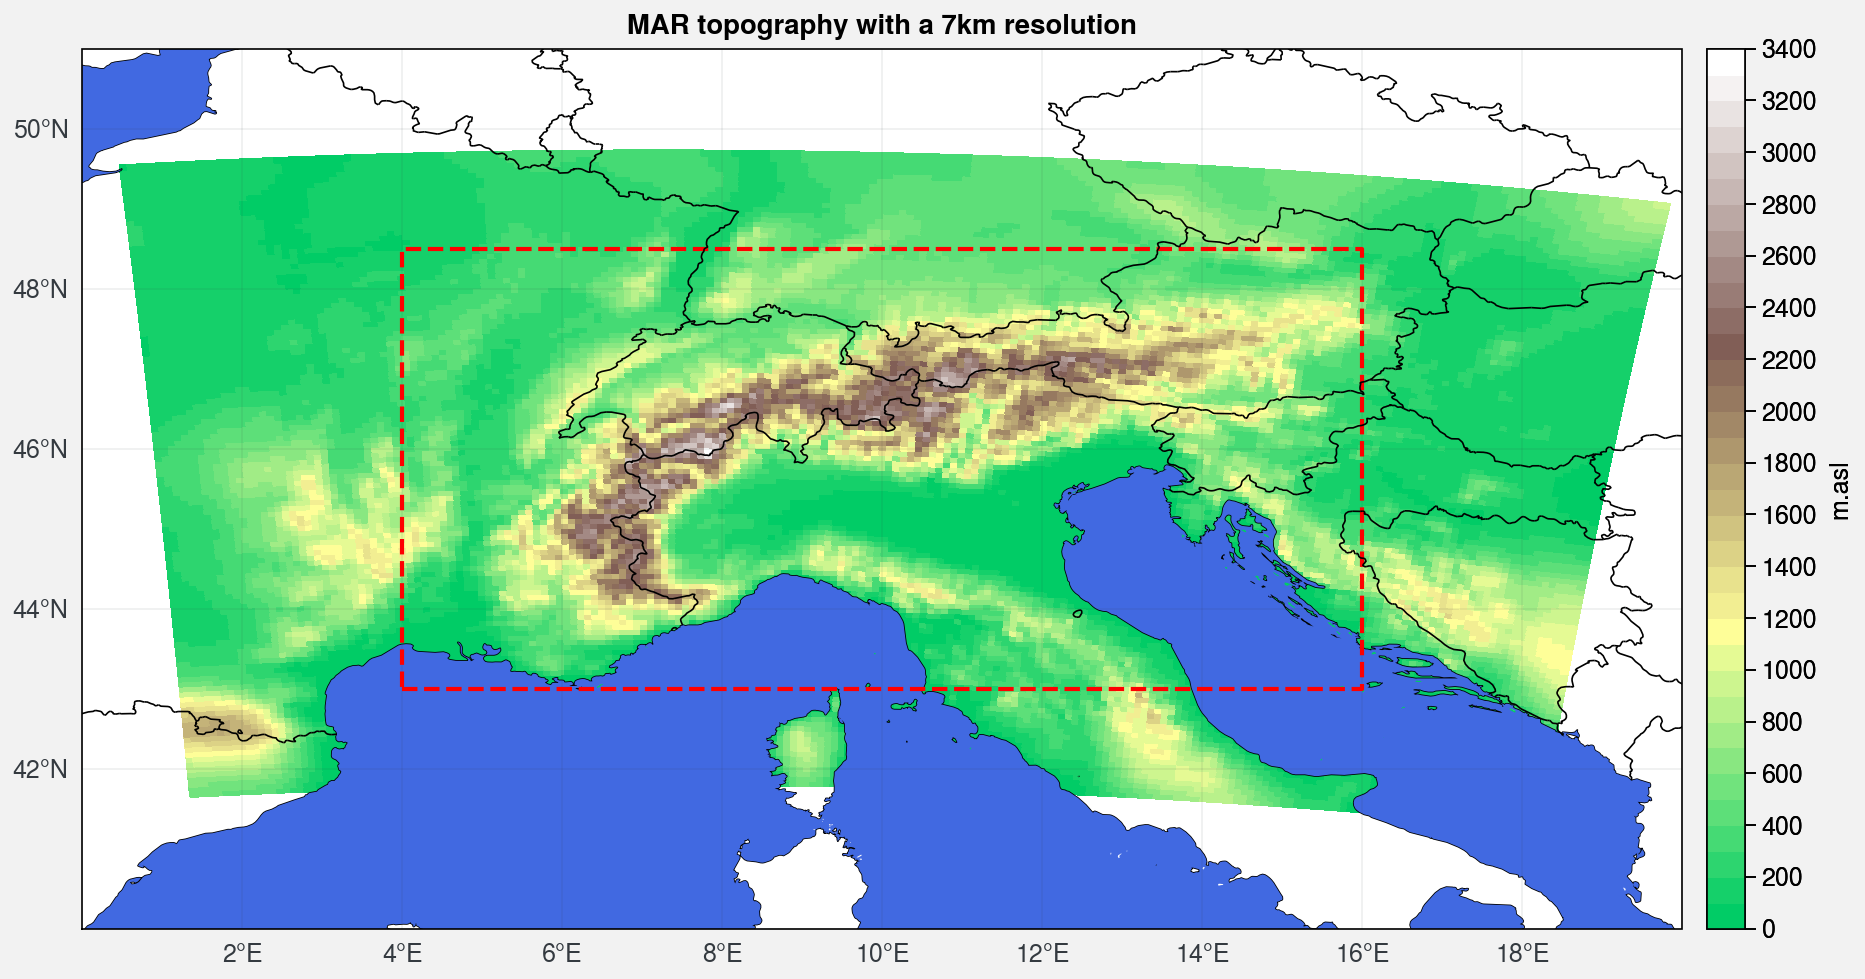

In [6]:
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=34,cmap=colors_land)
f.colorbar(m,label= 'm.asl')
ax.format(**normal_format,suptitle='MAR topography with a 7km resolution')
ax.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[40.,51.],lonlim=[0.,20.])
ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

**3 Seasonal means**

In [6]:
# function for seasonal mean
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")

In [21]:
# first_year = 1980
# last_year = 2020
# les_season_mean = np.zeros(((last_year-first_year+1),4,126,201))
# for year in list(range(first_year,last_year+1)):
#     print(year,end=' ')
#     ds_rr = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.MBrr.'+str(year)+'.nc')
#     ds_sf = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.MBsf.'+str(year)+'.nc')
#     season_mean_year=season_mean(ds_rr.MBrr+ds_sf.MBsf).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
#     les_season_mean[year-first_year] = season_mean_year
    
# print(les_season_mean.shape)
# np.save('/home/philinat/Stage-M2/saved_data_MAR_ERA5_daily_mean_max/les_season_mean.npy', les_season_mean)

1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 (41, 4, 126, 201)


In [7]:
first_year = 1980
last_year = 2020
les_season_meanT = np.zeros(((last_year-first_year+1),4,126,201))
les_season_maxT = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.TTz.'+str(year)+'.nc')
    ds_max = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.TTmax.'+str(year)+'.nc')
    
    season_mean_year=season_mean(ds_mean.TTz.isel(ztqlev=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    les_season_meanT[year-first_year] = season_mean_year
    season_max_year=(ds_max.TTmax.isel(atmlay=0)).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    les_season_maxT[year-first_year] = season_max_year

1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 

In [8]:
np.save('/home/philinat/Stage-M2/saved_data_MAR_ERA5/les_season_meanT.npy', les_season_meanT)
np.save('/home/philinat/Stage-M2/saved_data_MAR_ERA5/les_season_maxT.npy', les_season_maxT)

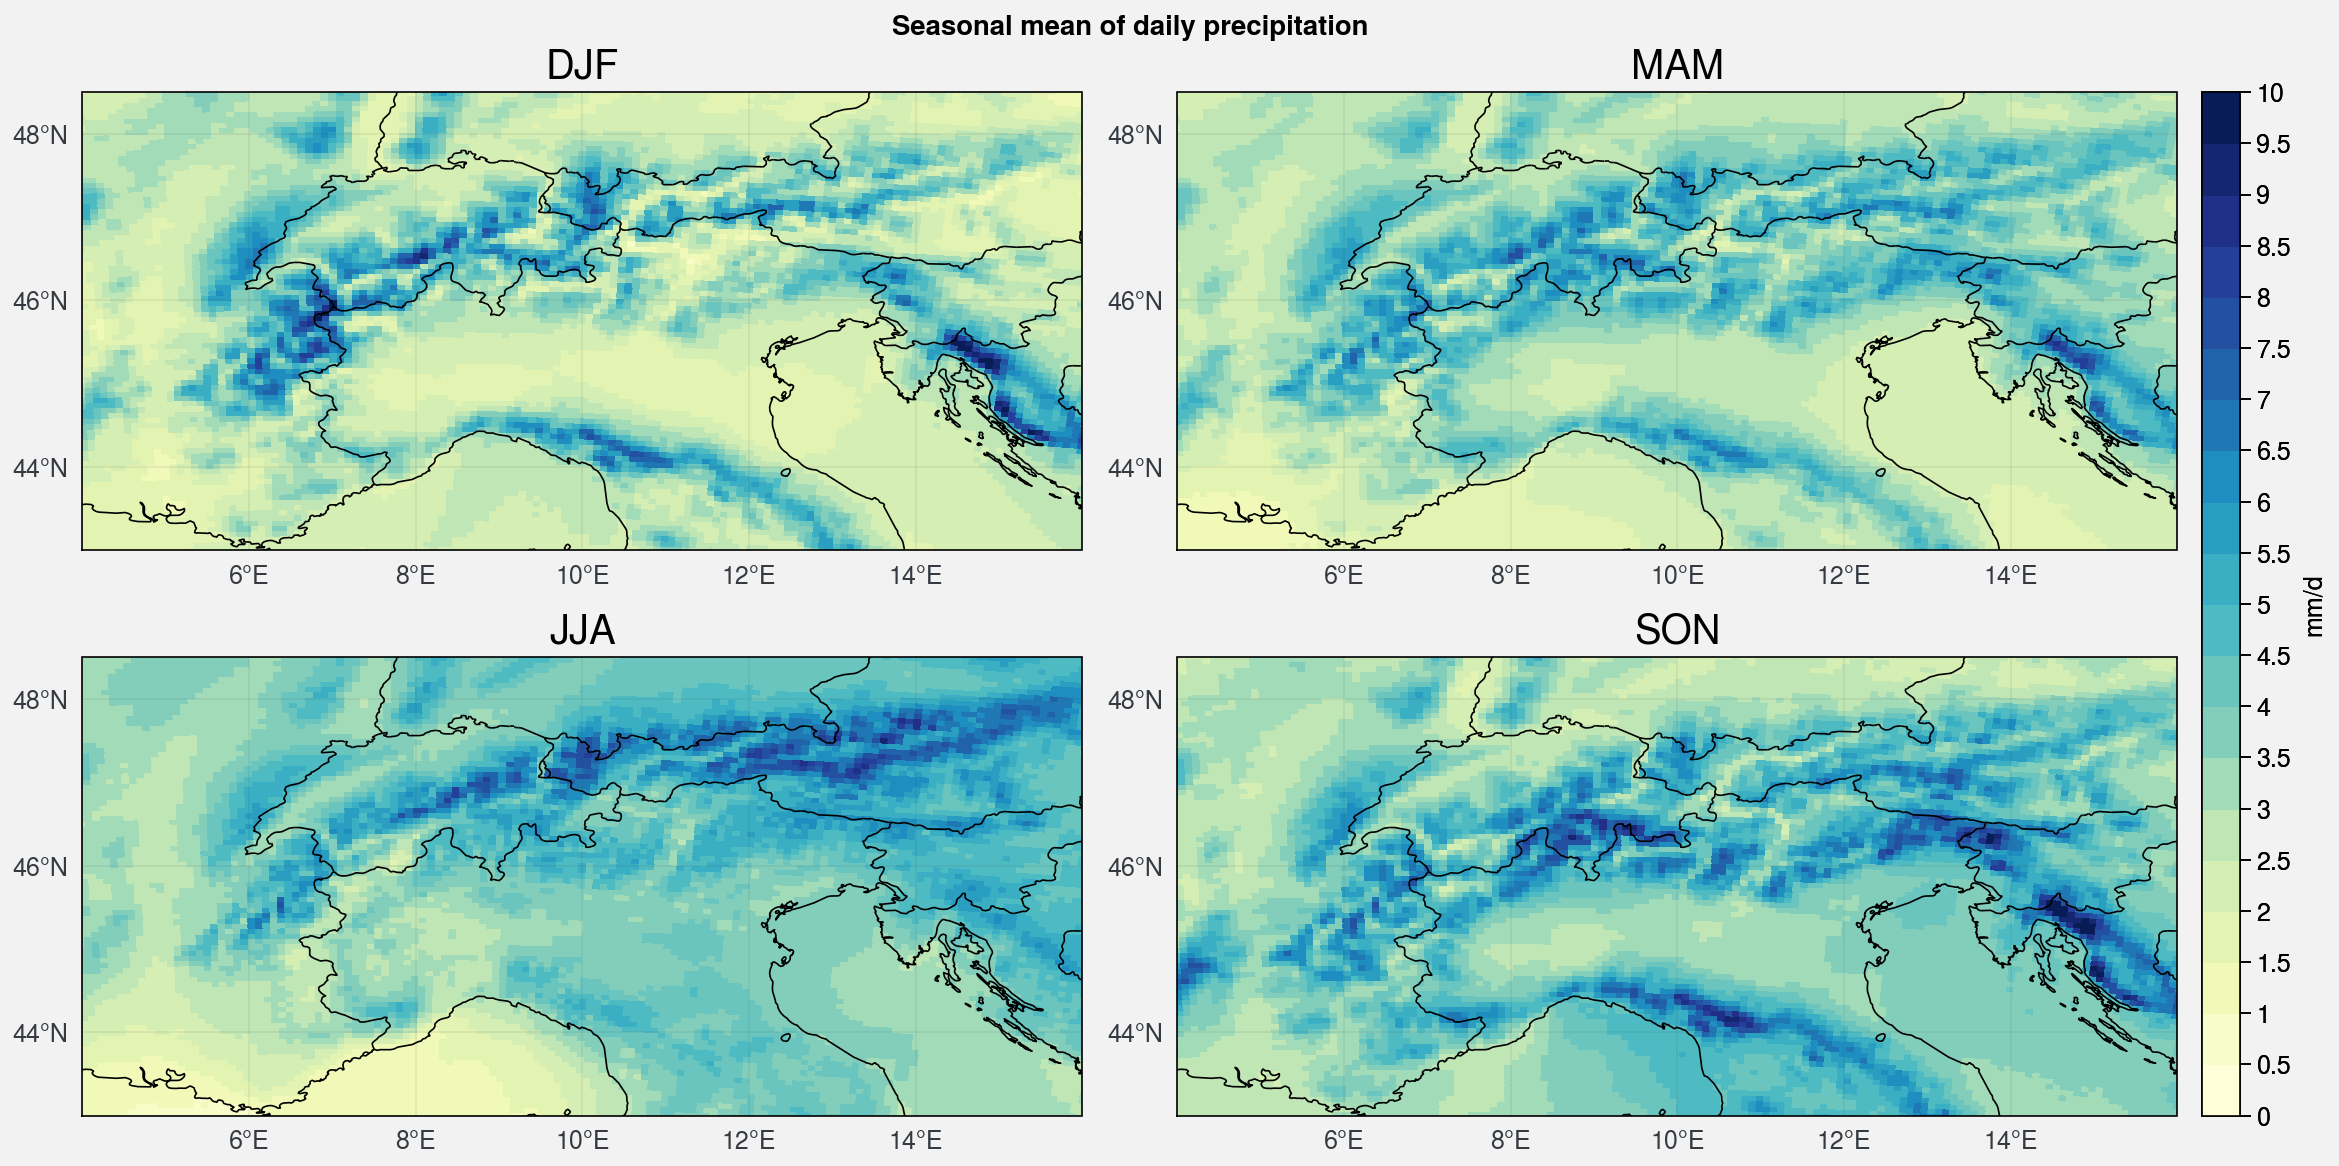

In [4]:
les_season_mean = np.load('/home/philinat/Stage-M2/saved_data_MAR_ERA5/les_season_mean.npy')
seasonal_mean = np.mean(les_season_mean,axis=0)
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_mean[i,:,:],levels=np.linspace(0,10,21),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Seasonal mean of daily precipitation")


**3.3 Relation precipitation/altitude**

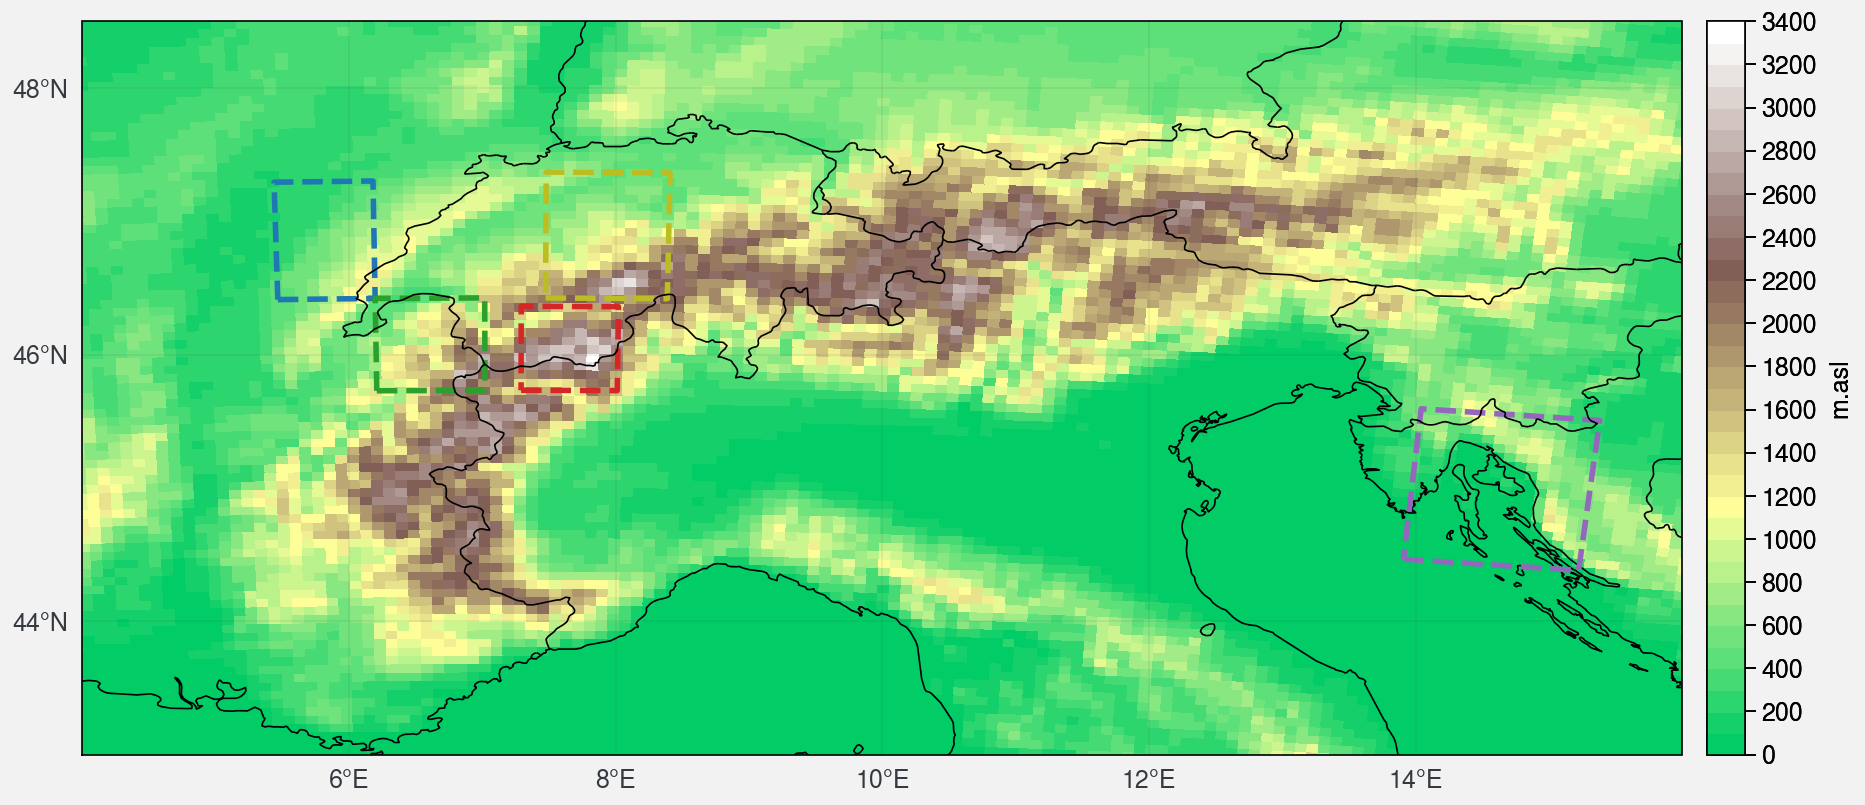

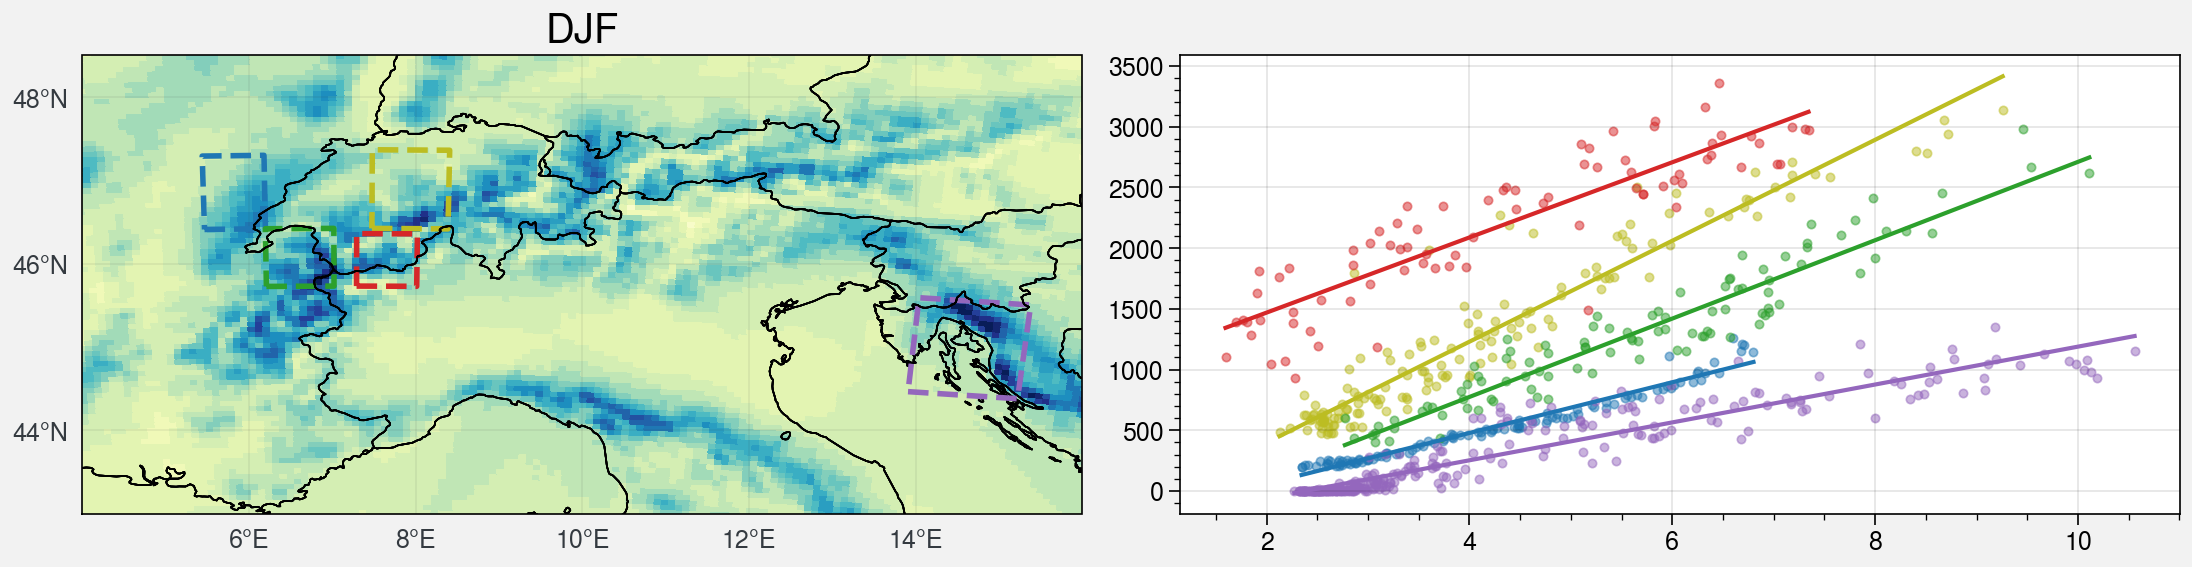

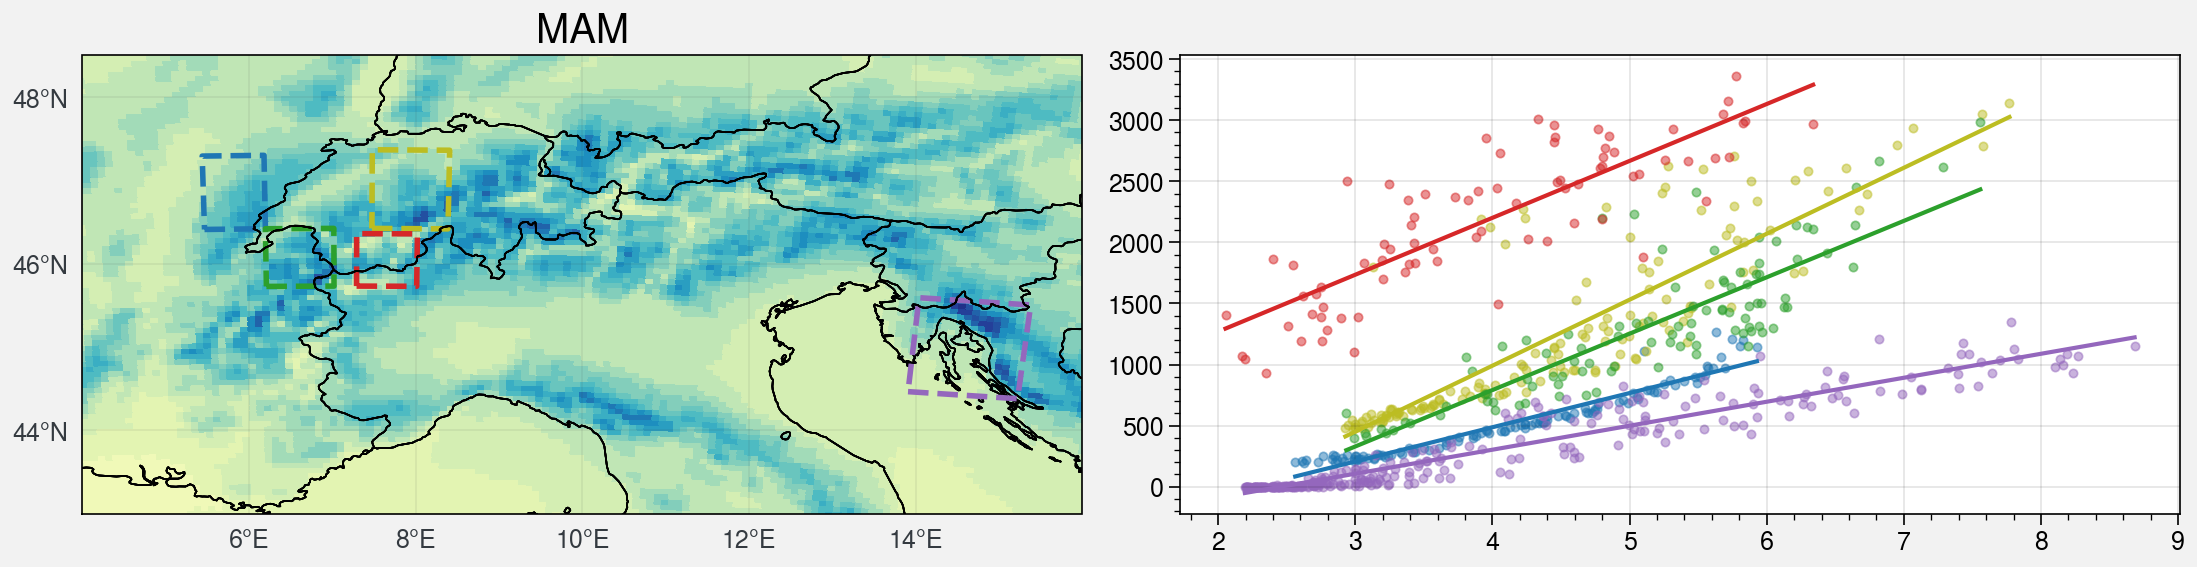

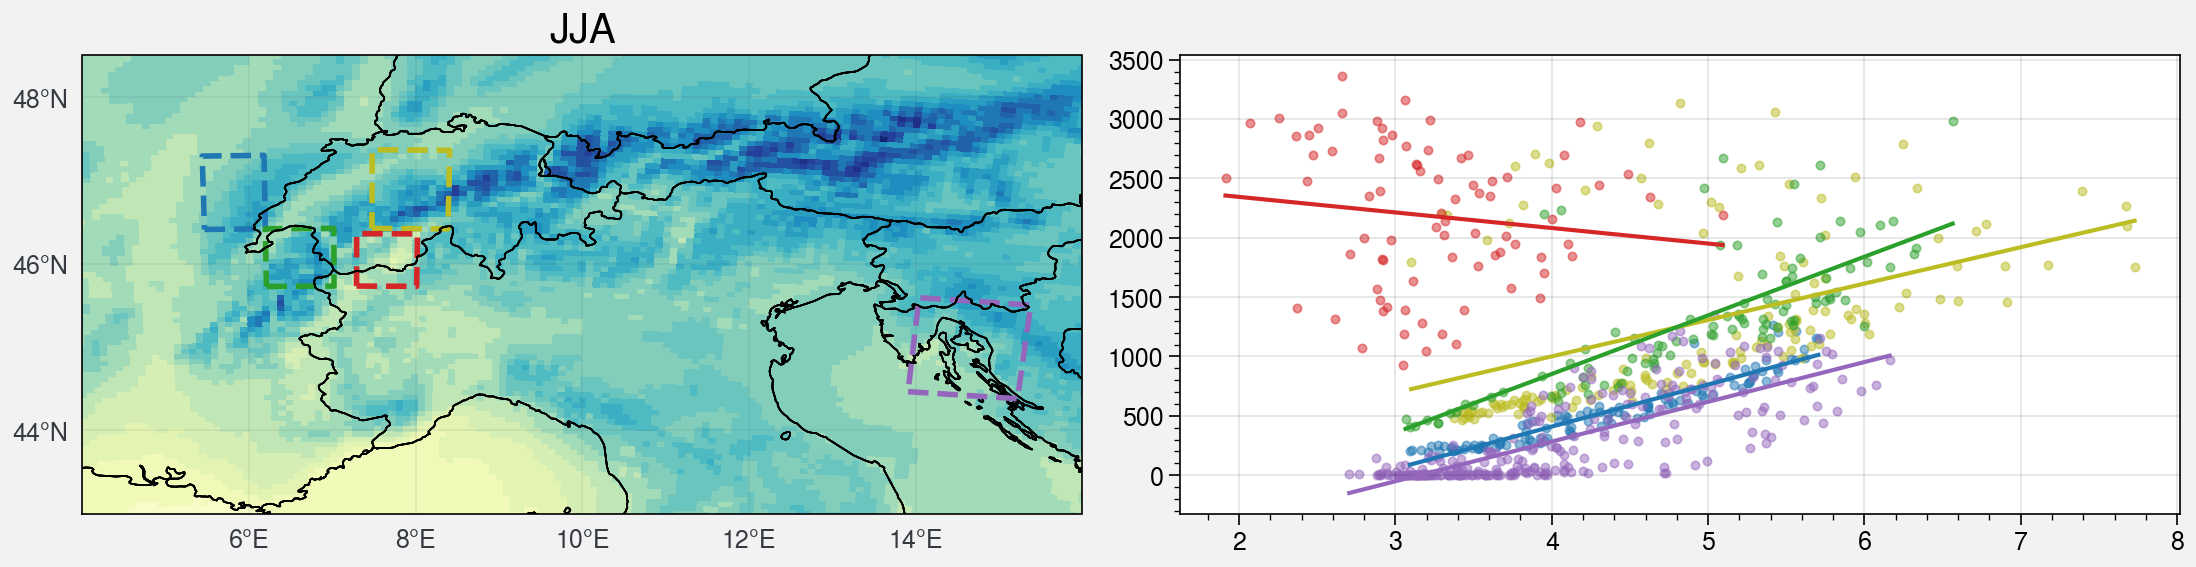

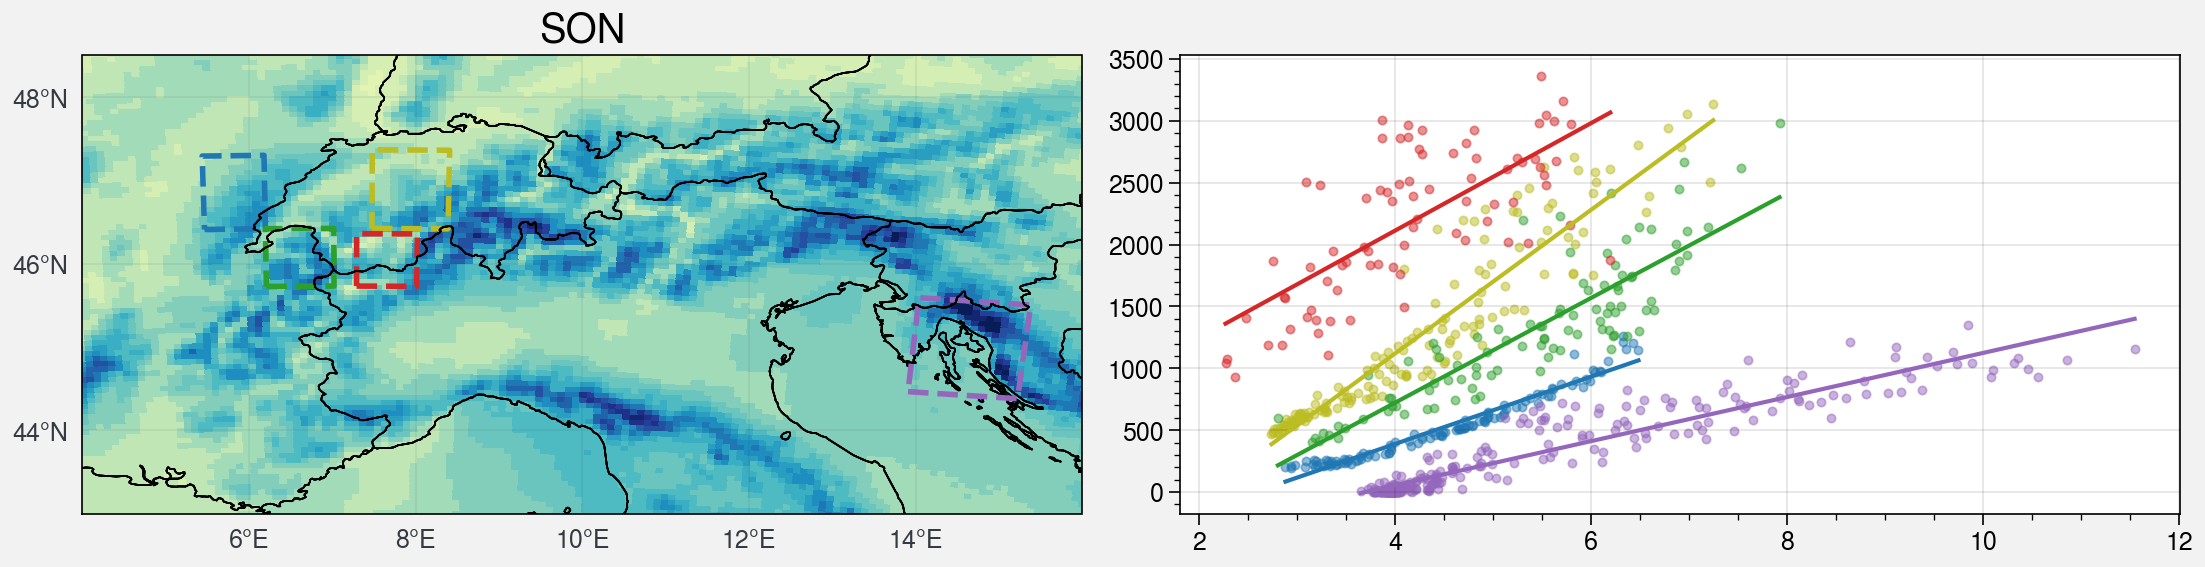

In [6]:
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
fh, axh = pplt.subplots(proj='cyl', axwidth=8)
m=axh.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=34,cmap=colors_land)
fh.colorbar(m,label= 'm.asl')
axh.format(**normal_format)#,ocean=True,oceancolor='royalblue',suptitle='7km topography')

colors = ['#1f77b4','#bcbd22', '#2ca02c', '#d62728', '#9467bd',  '#ff7f0e', '#17becf']

for season in range(4):
    f, axs = pplt.subplots(proj=('cyl',None),ncols=2, nrows=1, share=1, axwidth=5)
    for region in range(5):
        if region==0:
            i1 = 50 ; i2 = 58 ; j1 = 73 ; j2 = 87 # jura
            # i1 = 100 ; i2 = 120 ; j1 = 35 ; j2 = 45 # appenins
        if region==1:
            i1 = 72 ; i2 = 82 ; j1 = 73 ; j2 = 88 # suisse
        if region==2:
            i1 = 58 ; i2 = 67 ; j1 = 62 ; j2 = 73 # savoie
        if region==3:
            i1 = 70 ; i2 = 78 ; j1 = 62 ; j2 = 72 # mont rose
        if region==4:
            i1 = 145 ; i2 = 160 ; j1 = 45 ; j2 = 63 # croatie
        if region==5:
            i1 = 123 ; i2 = 137 ; j1 = 84 ; j2 = 90 # grossglokner
            # i1 = 100 ; i2 = 130 ; j1 = 82 ; j2 = 92 # tirol
            # i1 = 105 ; i2 = 120 ; j1 = 65 ; j2 = 80 # sud tirol

        m = axs[0].pcolormesh(ds.LON,ds.LAT,seasonal_mean[season,:,:],levels=np.linspace(0,10,21),cmap='YlGnBu' )
        axs[0].format(**normal_format,title=['DJF','MAM','JJA', 'SON'][season],titlesize='20px')

        axs[0].plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
        if season==0:
            axh.plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
        
        
        h = np.array(ds.SH[j1:j2,i1:i2].stack(z=('x','y')) )
        p = np.ndarray.flatten(seasonal_mean[season,j1:j2,i1:i2],order='F')
        #p = seasonal_mean[season,j1:j2,i1:i2].stack(z=('x','y'))
        axs[1].scatter( p, h ,marker='.',alpha=0.5,color=colors[region])

        m, b = np.polyfit(p, h, 1)
        x= np.linspace(np.min(p),np.max(p),2)
        axs[1].plot(x, m*x + b,color=colors[region])

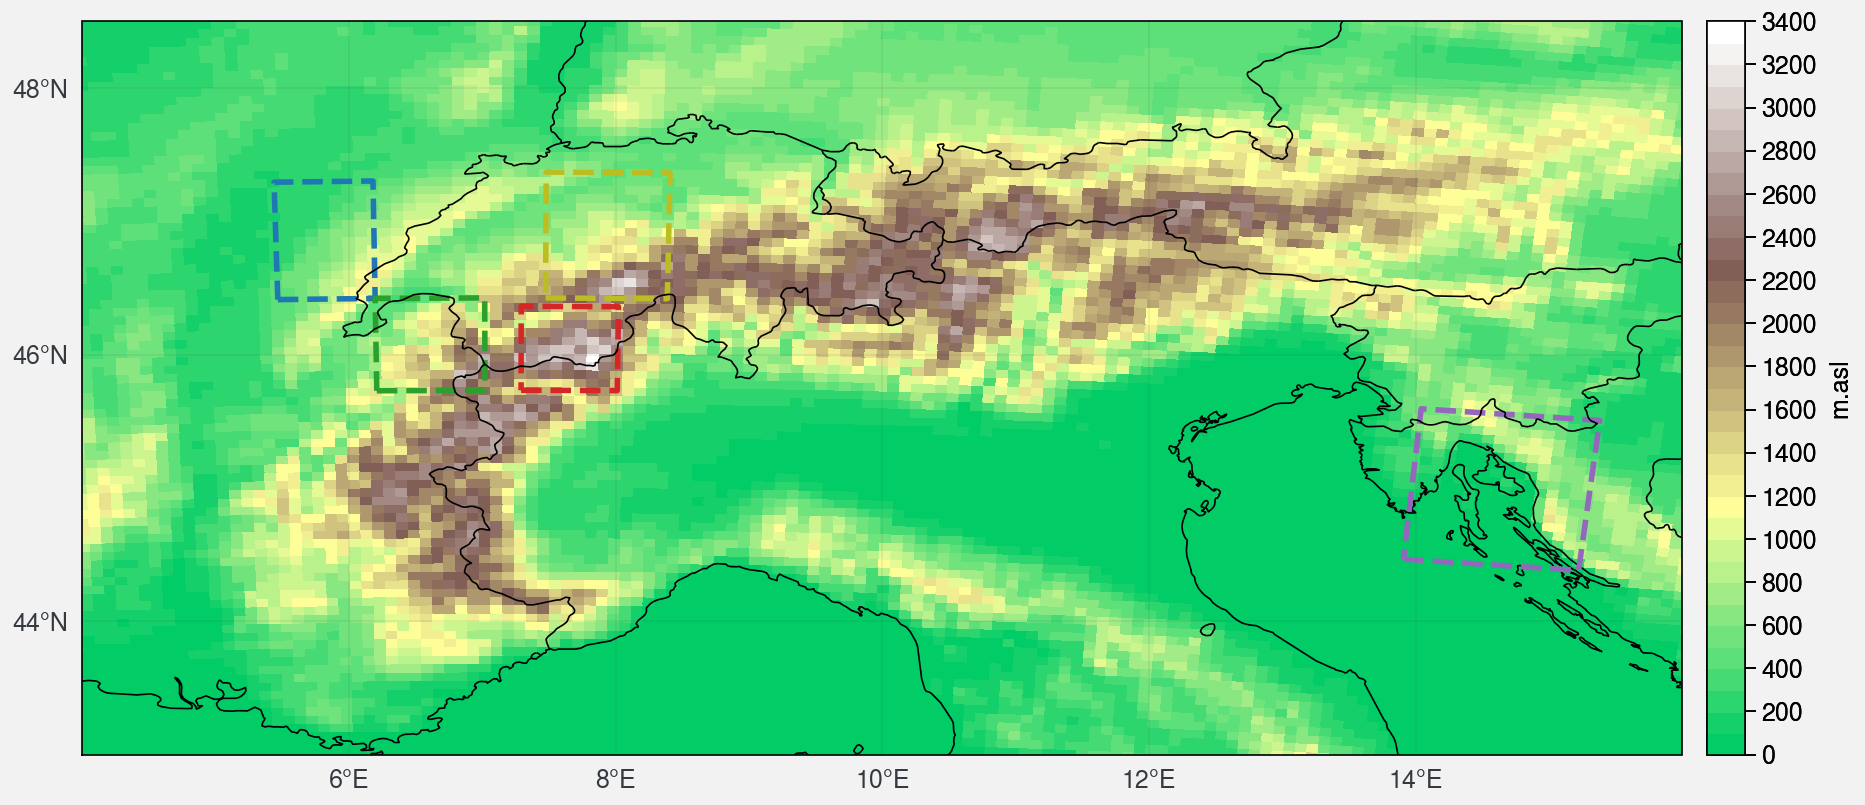

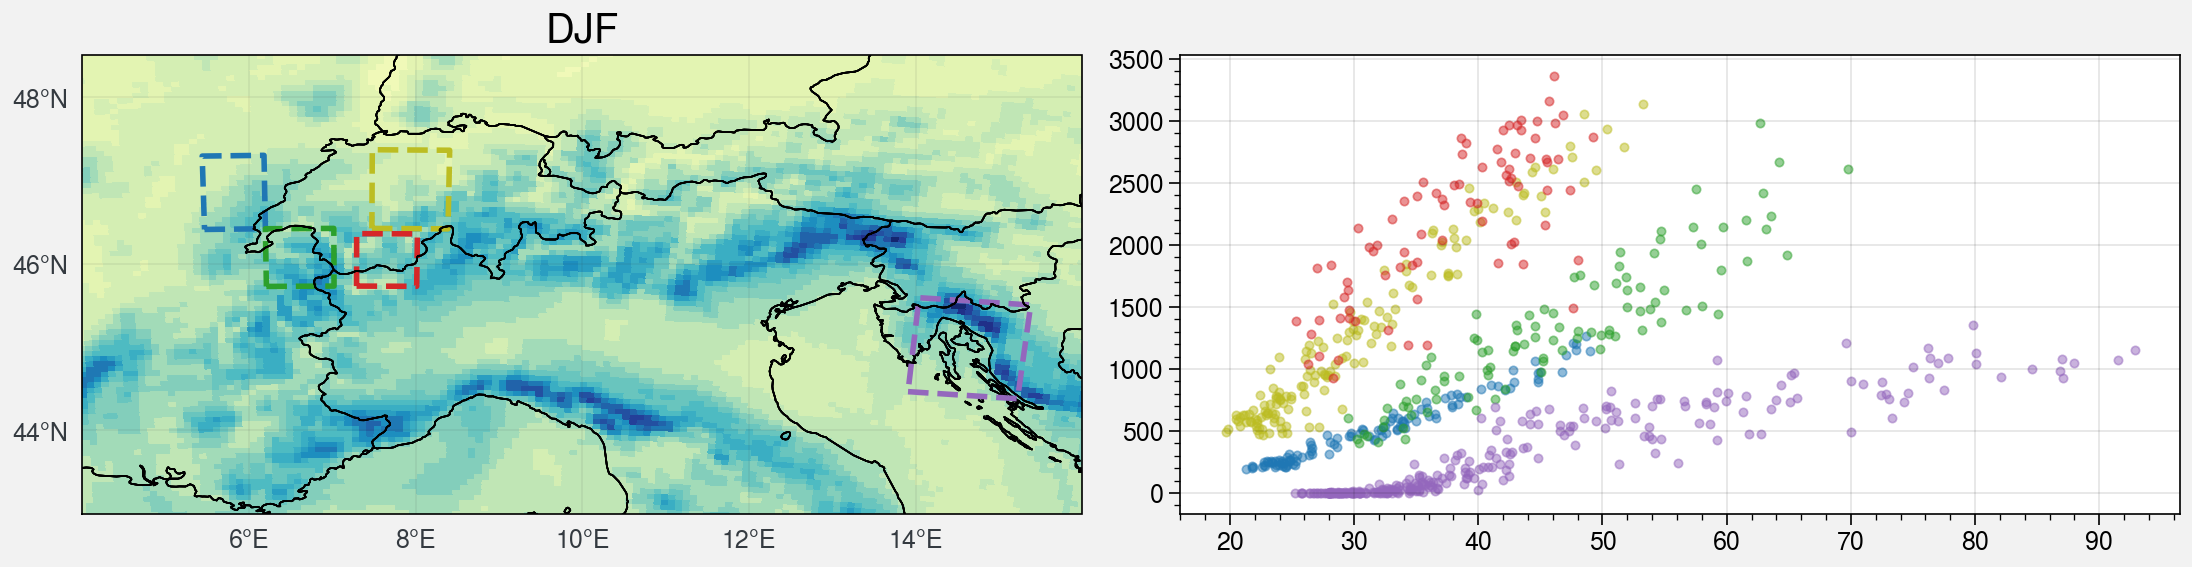

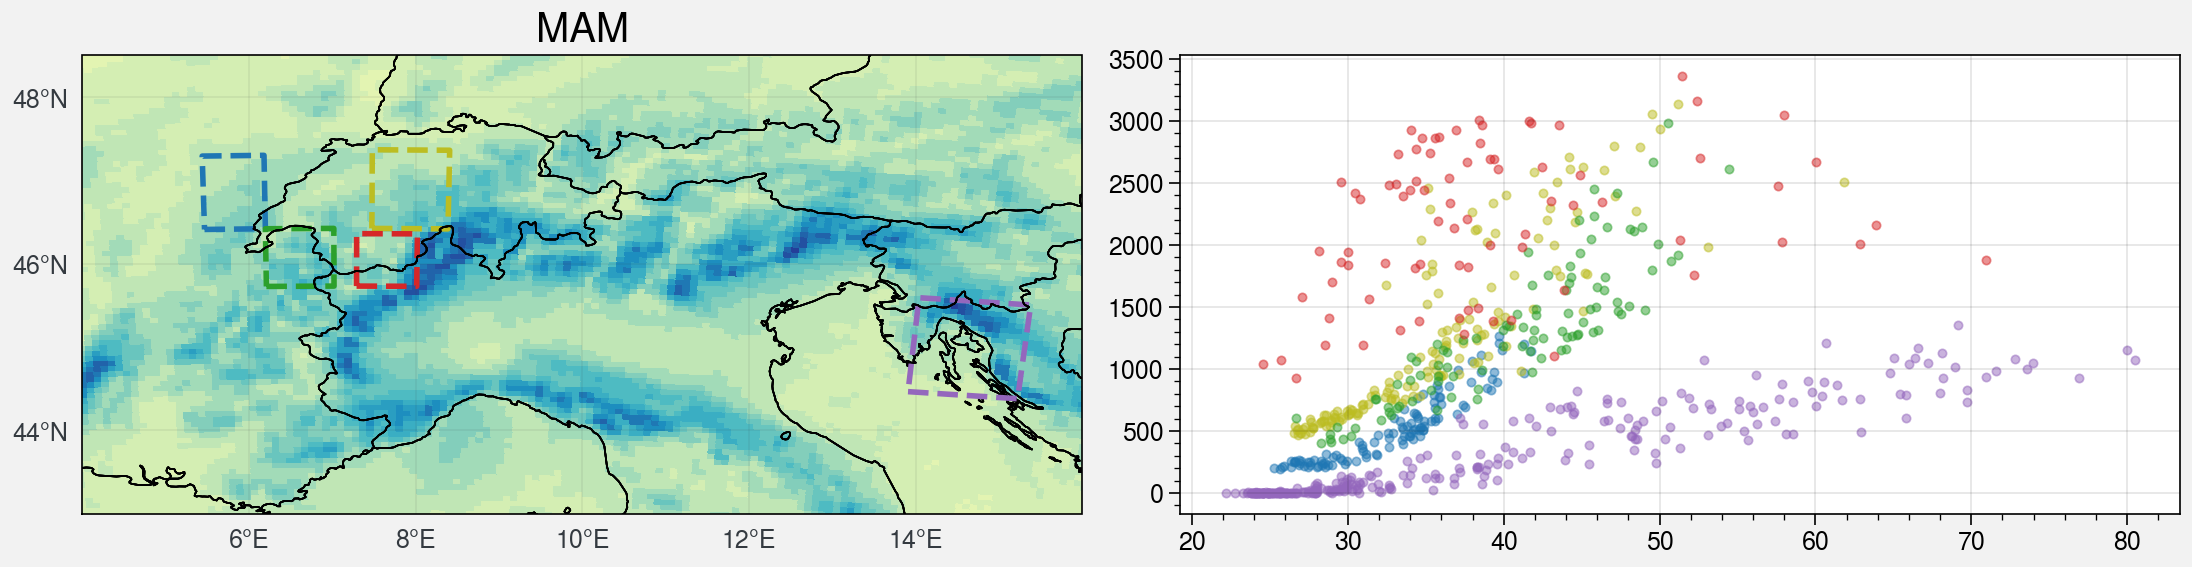

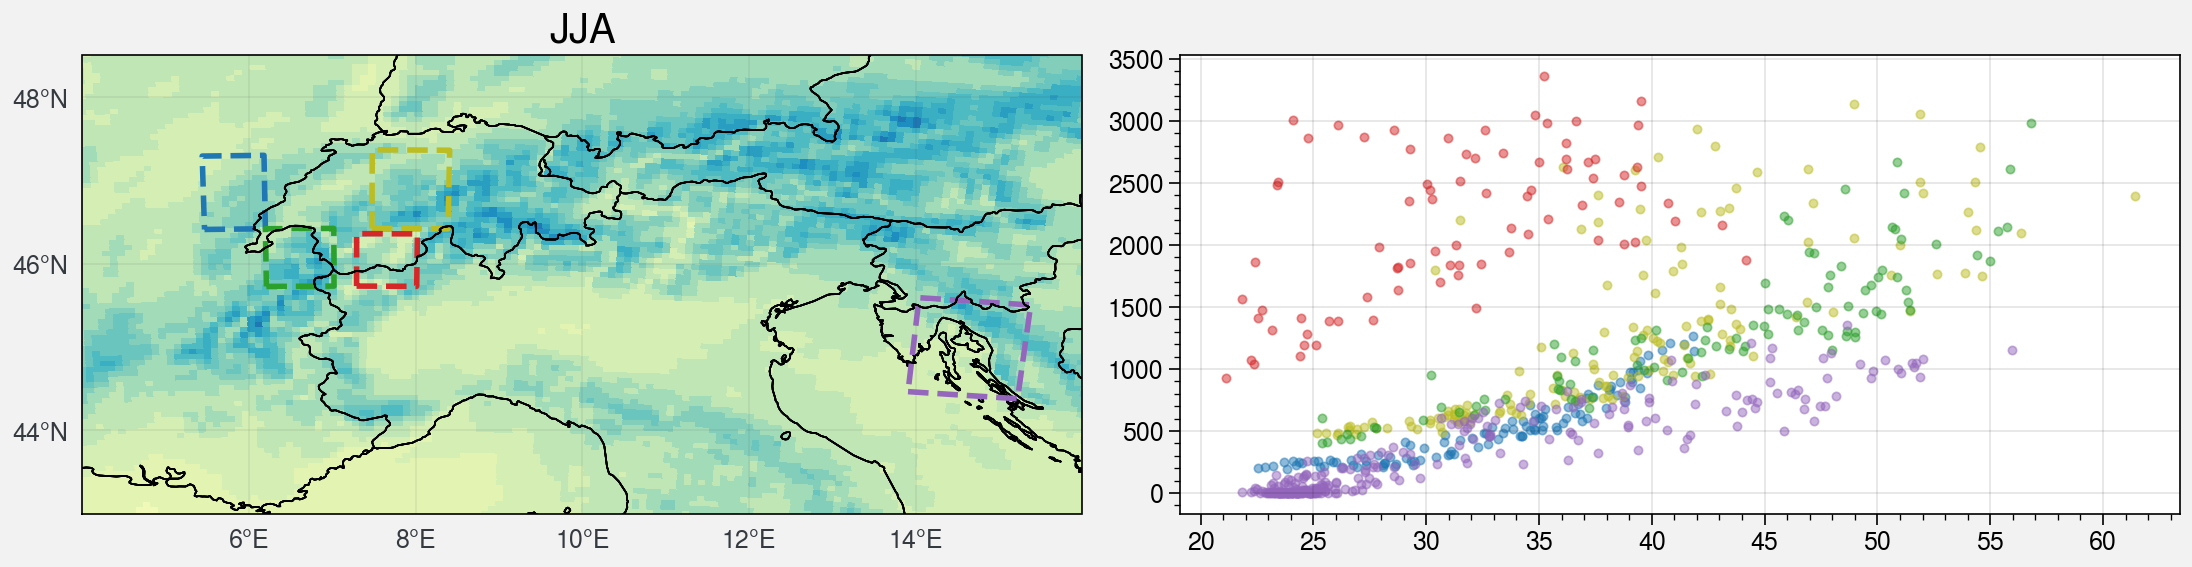

In [ ]:
les_season_max = np.load('/home/philinat/Stage-M2/saved_data_MAR_ERA5/les_season_max.npy')
seasonal_mean = np.mean(les_season_max,axis=0)

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
fh, axh = pplt.subplots(proj='cyl', axwidth=8)
m=axh.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=34,cmap=colors_land)
fh.colorbar(m,label= 'm.asl')
axh.format(**normal_format)#,ocean=True,oceancolor='royalblue',suptitle='7km topography')

colors = ['#1f77b4','#bcbd22', '#2ca02c', '#d62728', '#9467bd',  '#ff7f0e', '#17becf']

for season in range(4):
    f, axs = pplt.subplots(proj=('cyl',None),ncols=2, nrows=1, share=1, axwidth=5)
    for region in range(5):
        if region==0:
            i1 = 50 ; i2 = 58 ; j1 = 73 ; j2 = 87 # jura
            # i1 = 100 ; i2 = 120 ; j1 = 35 ; j2 = 45 # appenins
        if region==1:
            i1 = 72 ; i2 = 82 ; j1 = 73 ; j2 = 88 # suisse
        if region==2:
            i1 = 58 ; i2 = 67 ; j1 = 62 ; j2 = 73 # savoie
        if region==3:
            i1 = 70 ; i2 = 78 ; j1 = 62 ; j2 = 72 # mont rose
        if region==4:
            i1 = 145 ; i2 = 160 ; j1 = 45 ; j2 = 63 # croatie
        if region==5:
            i1 = 123 ; i2 = 137 ; j1 = 84 ; j2 = 90 # grossglokner
            # i1 = 100 ; i2 = 130 ; j1 = 82 ; j2 = 92 # tirol
            # i1 = 105 ; i2 = 120 ; j1 = 65 ; j2 = 80 # sud tirol

        m = axs[0].pcolormesh(ds.LON,ds.LAT,seasonal_mean[season,:,:],levels=np.linspace(0,100,21),cmap='YlGnBu' )
        axs[0].format(**normal_format,title=['DJF','MAM','JJA', 'SON'][season],titlesize='20px')

        axs[0].plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
        if season==0:
            axh.plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
            
        h = np.array(ds.SH[j1:j2,i1:i2].stack(z=('x','y')) )
        p = np.ndarray.flatten(seasonal_mean[season,j1:j2,i1:i2],order='F')
        #p = seasonal_mean[season,j1:j2,i1:i2].stack(z=('x','y'))
        axs[1].scatter( p, h ,marker='.',alpha=0.5,color=colors[region])

        # m, b = np.polyfit(p, h, 1)
        # x= np.linspace(np.min(p),np.max(p),2)
        # axs[1].plot(x, m*x + b,color=colors[region])

In [ ]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
les_season_max = np.load('/home/philinat/Stage-M2/saved_data_APGD/les_season_max.npy')
seasonal_mean = np.mean(les_season_max,axis=0)

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
fh, axh = pplt.subplots(proj='cyl', axwidth=8)
m=axh.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=34,cmap=colors_land)
fh.colorbar(m,label= 'm.asl')
axh.format(**normal_format)#,ocean=True,oceancolor='royalblue',suptitle='7km topography')

colors = ['#1f77b4','#bcbd22', '#2ca02c', '#d62728', '#9467bd',  '#ff7f0e', '#17becf']

for season in range(4):
    f, axs = pplt.subplots(proj=('cyl',None),ncols=2, nrows=1, share=1, axwidth=5)
    for region in range(5):
        if region==0:
            i1 = 50 ; i2 = 58 ; j1 = 73 ; j2 = 87 # jura
            # i1 = 100 ; i2 = 120 ; j1 = 35 ; j2 = 45 # appenins
        if region==1:
            i1 = 72 ; i2 = 82 ; j1 = 73 ; j2 = 88 # suisse
        if region==2:
            i1 = 58 ; i2 = 67 ; j1 = 62 ; j2 = 73 # savoie
        if region==3:
            i1 = 70 ; i2 = 78 ; j1 = 62 ; j2 = 72 # mont rose
        if region==4:
            i1 = 145 ; i2 = 160 ; j1 = 45 ; j2 = 63 # croatie
        if region==5:
            i1 = 123 ; i2 = 137 ; j1 = 84 ; j2 = 90 # grossglokner
            # i1 = 100 ; i2 = 130 ; j1 = 82 ; j2 = 92 # tirol
            # i1 = 105 ; i2 = 120 ; j1 = 65 ; j2 = 80 # sud tirol

        m = axs[0].pcolormesh(ds.LON,ds.LAT,seasonal_mean[season,:,:],levels=np.linspace(0,100,21),cmap='YlGnBu' )
        axs[0].format(**normal_format,title=['DJF','MAM','JJA', 'SON'][season],titlesize='20px')

        axs[0].plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
        if season==0:
            axh.plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
            
        h = np.array(ds.SH[j1:j2,i1:i2].stack(z=('x','y')) )
        p = np.ndarray.flatten(seasonal_mean[season,j1:j2,i1:i2],order='F')
        #p = seasonal_mean[season,j1:j2,i1:i2].stack(z=('x','y'))
        axs[1].scatter( p, h ,marker='.',alpha=0.5,color=colors[region])

        # m, b = np.polyfit(p, h, 1)
        # x= np.linspace(np.min(p),np.max(p),2)
        # axs[1].plot(x, m*x + b,color=colors[region])

**4 Extremes**

In [16]:
# first_year = 1980
# last_year = 2020
# les_season_max = np.zeros(((last_year-first_year+1),4,126,201))
# for year in list(range(first_year,last_year+1)):
#     print(year,end=' ')
#     ds_rr = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.MBrr.'+str(year)+'.nc')
#     ds_sf = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.MBsf.'+str(year)+'.nc')
#     season_max_year=(ds_rr.MBrr+ds_sf.MBsf).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
#     les_season_max[year-first_year] = season_max_year
    
# print(les_season_max.shape)
# np.save('/home/philinat/Stage-M2/saved_data_MAR_ERA5_daily_mean_max/les_season_max.npy', les_season_max)

1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 (41, 4, 126, 201)


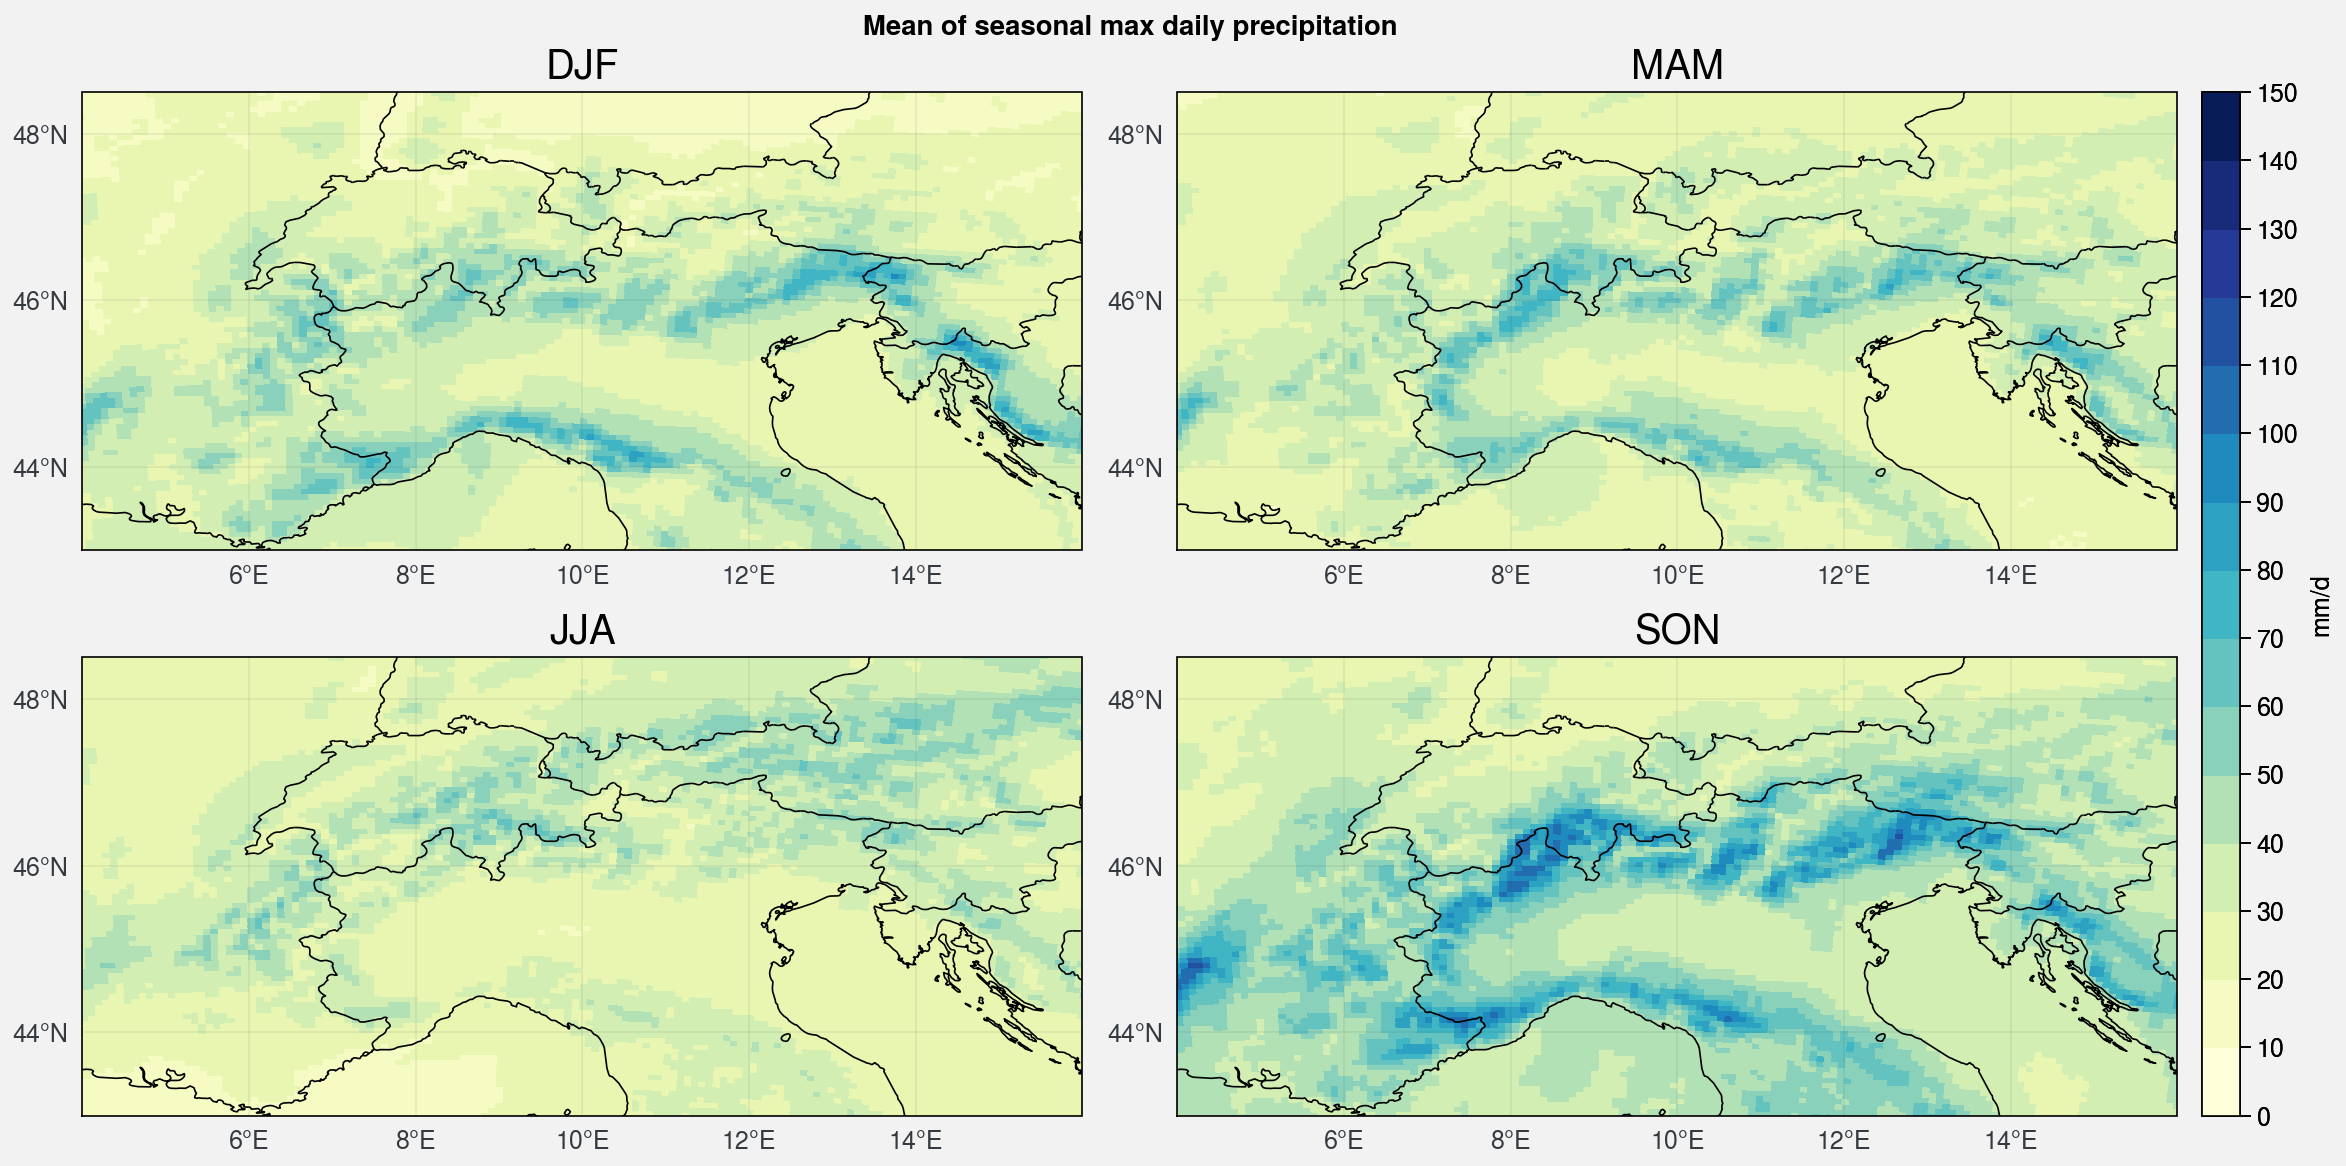

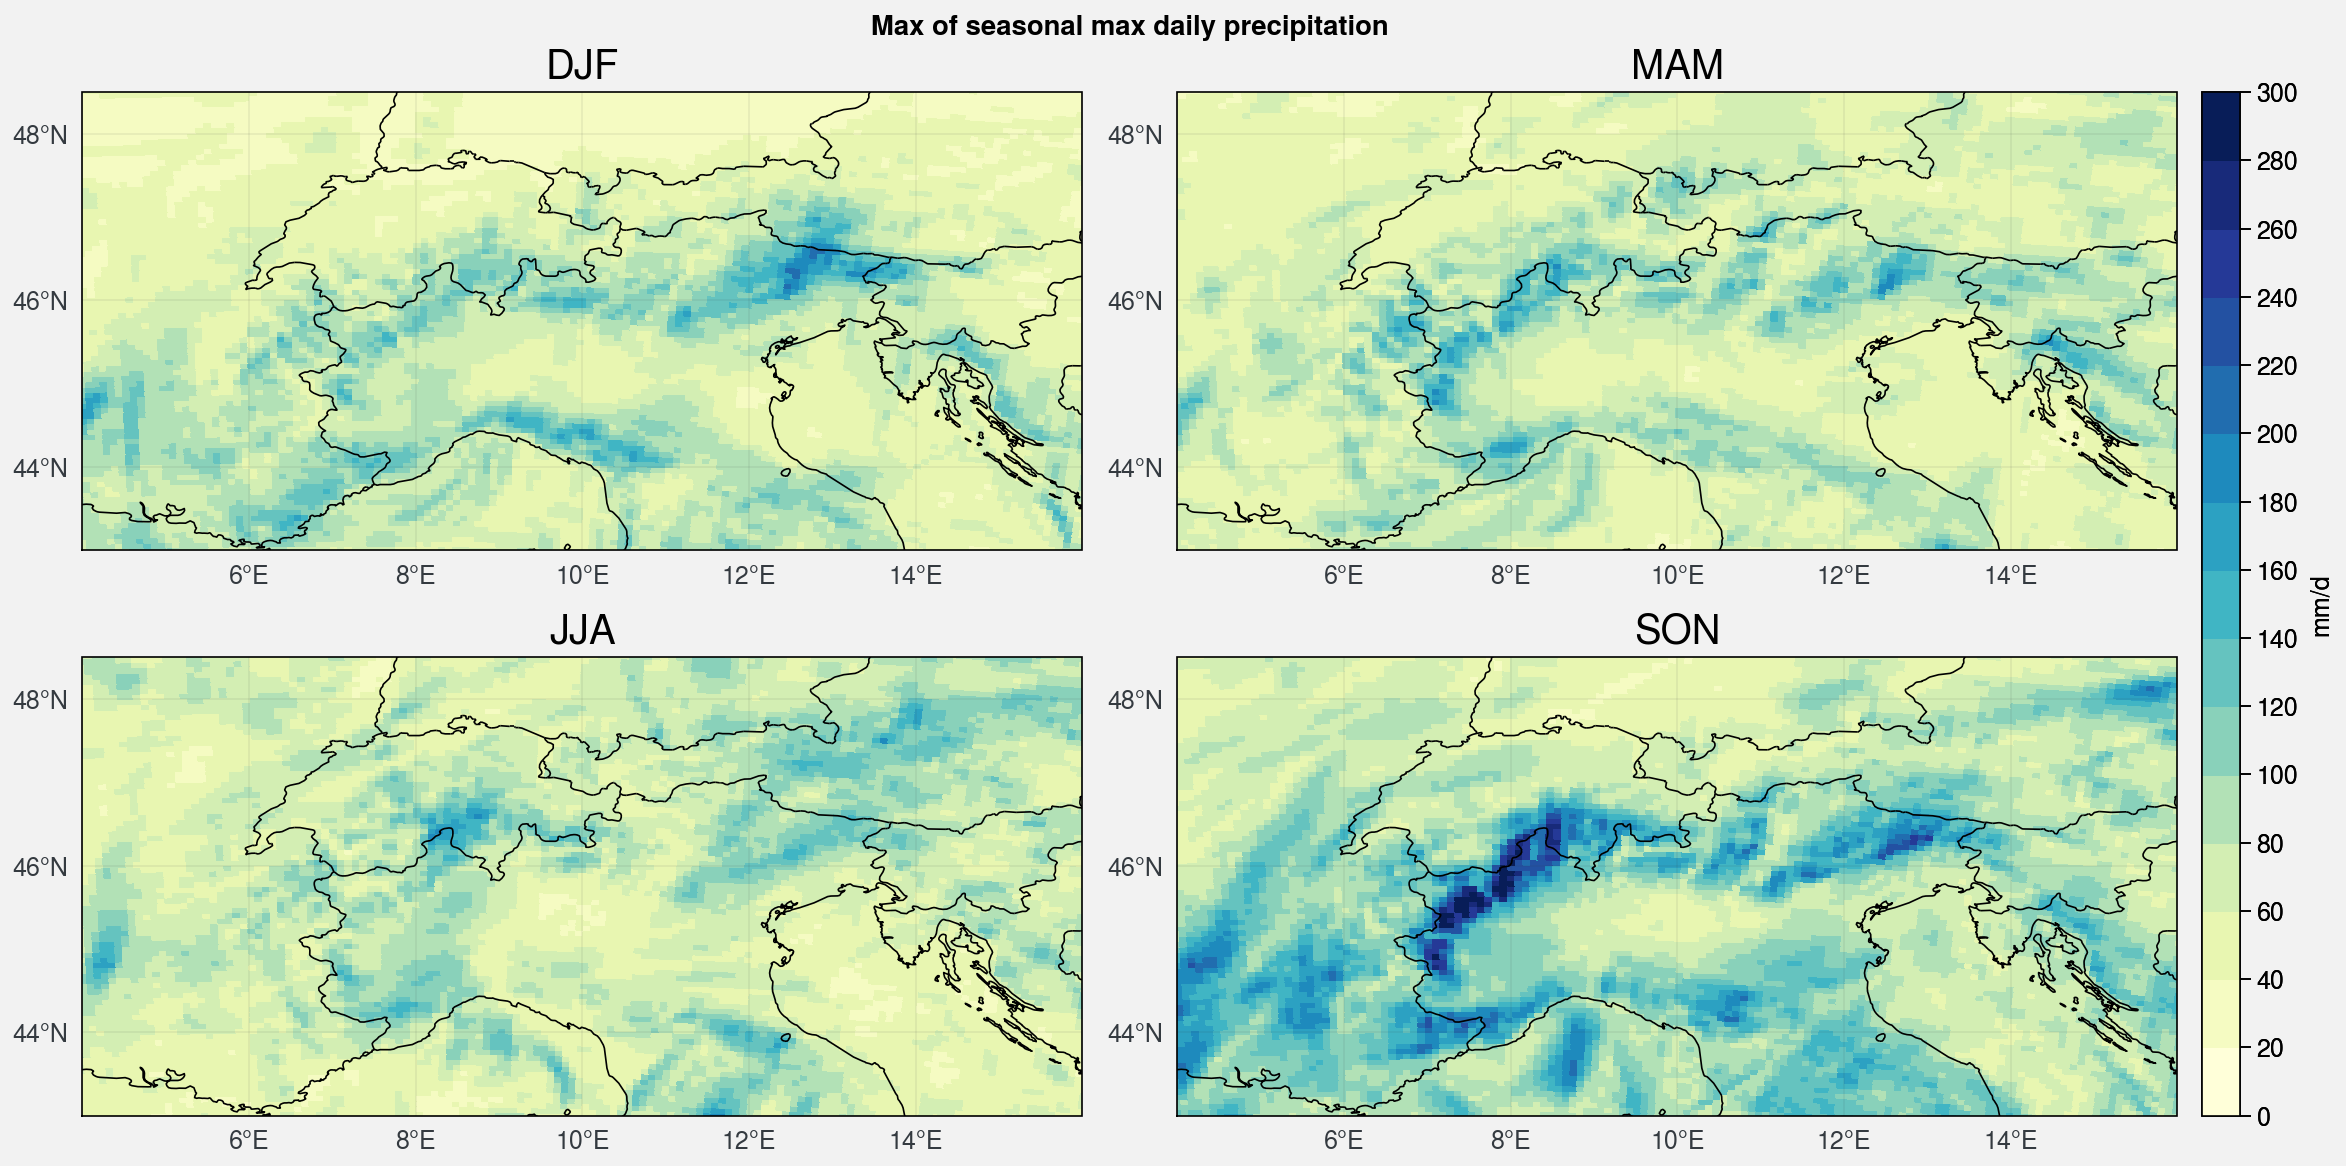

In [3]:
les_season_max = np.load('/home/philinat/Stage-M2/saved_data_MAR_ERA5_daily_mean_max/les_season_max.npy')
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,np.mean(les_season_max[:,i,:,:],axis=0),levels=np.linspace(0,150,16),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Mean of seasonal max daily precipitation")

f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,np.max(les_season_max[:,i,:,:],axis=0),levels=np.linspace(0,300,16),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Max of seasonal max daily precipitation")

In [ ]:
#season_gev_map = np.zeros((3,4,126,201))
for i in range(150,201):
    print(i,end=' ')
    for j in range(126):
        for season in range(4):
            season_gev_map[:,season,j,i] =  gev.fit(les_season_max[:,season,j,i])

150 

/home/philinat/miniconda3/envs/erca/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/home/philinat/miniconda3/envs/erca/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 

In [10]:
np.save('/home/philinat/Stage-M2/saved_data_MAR_ERA5_daily_mean_max/season_gev_map.npy', season_gev_map)

In [4]:
season_gev_map = np.load('/home/philinat/Stage-M2/saved_data_MAR_ERA5_daily_mean_max/season_gev_map.npy')

/home/philinat/miniconda3/envs/erca/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/philinat/miniconda3/envs/erca/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


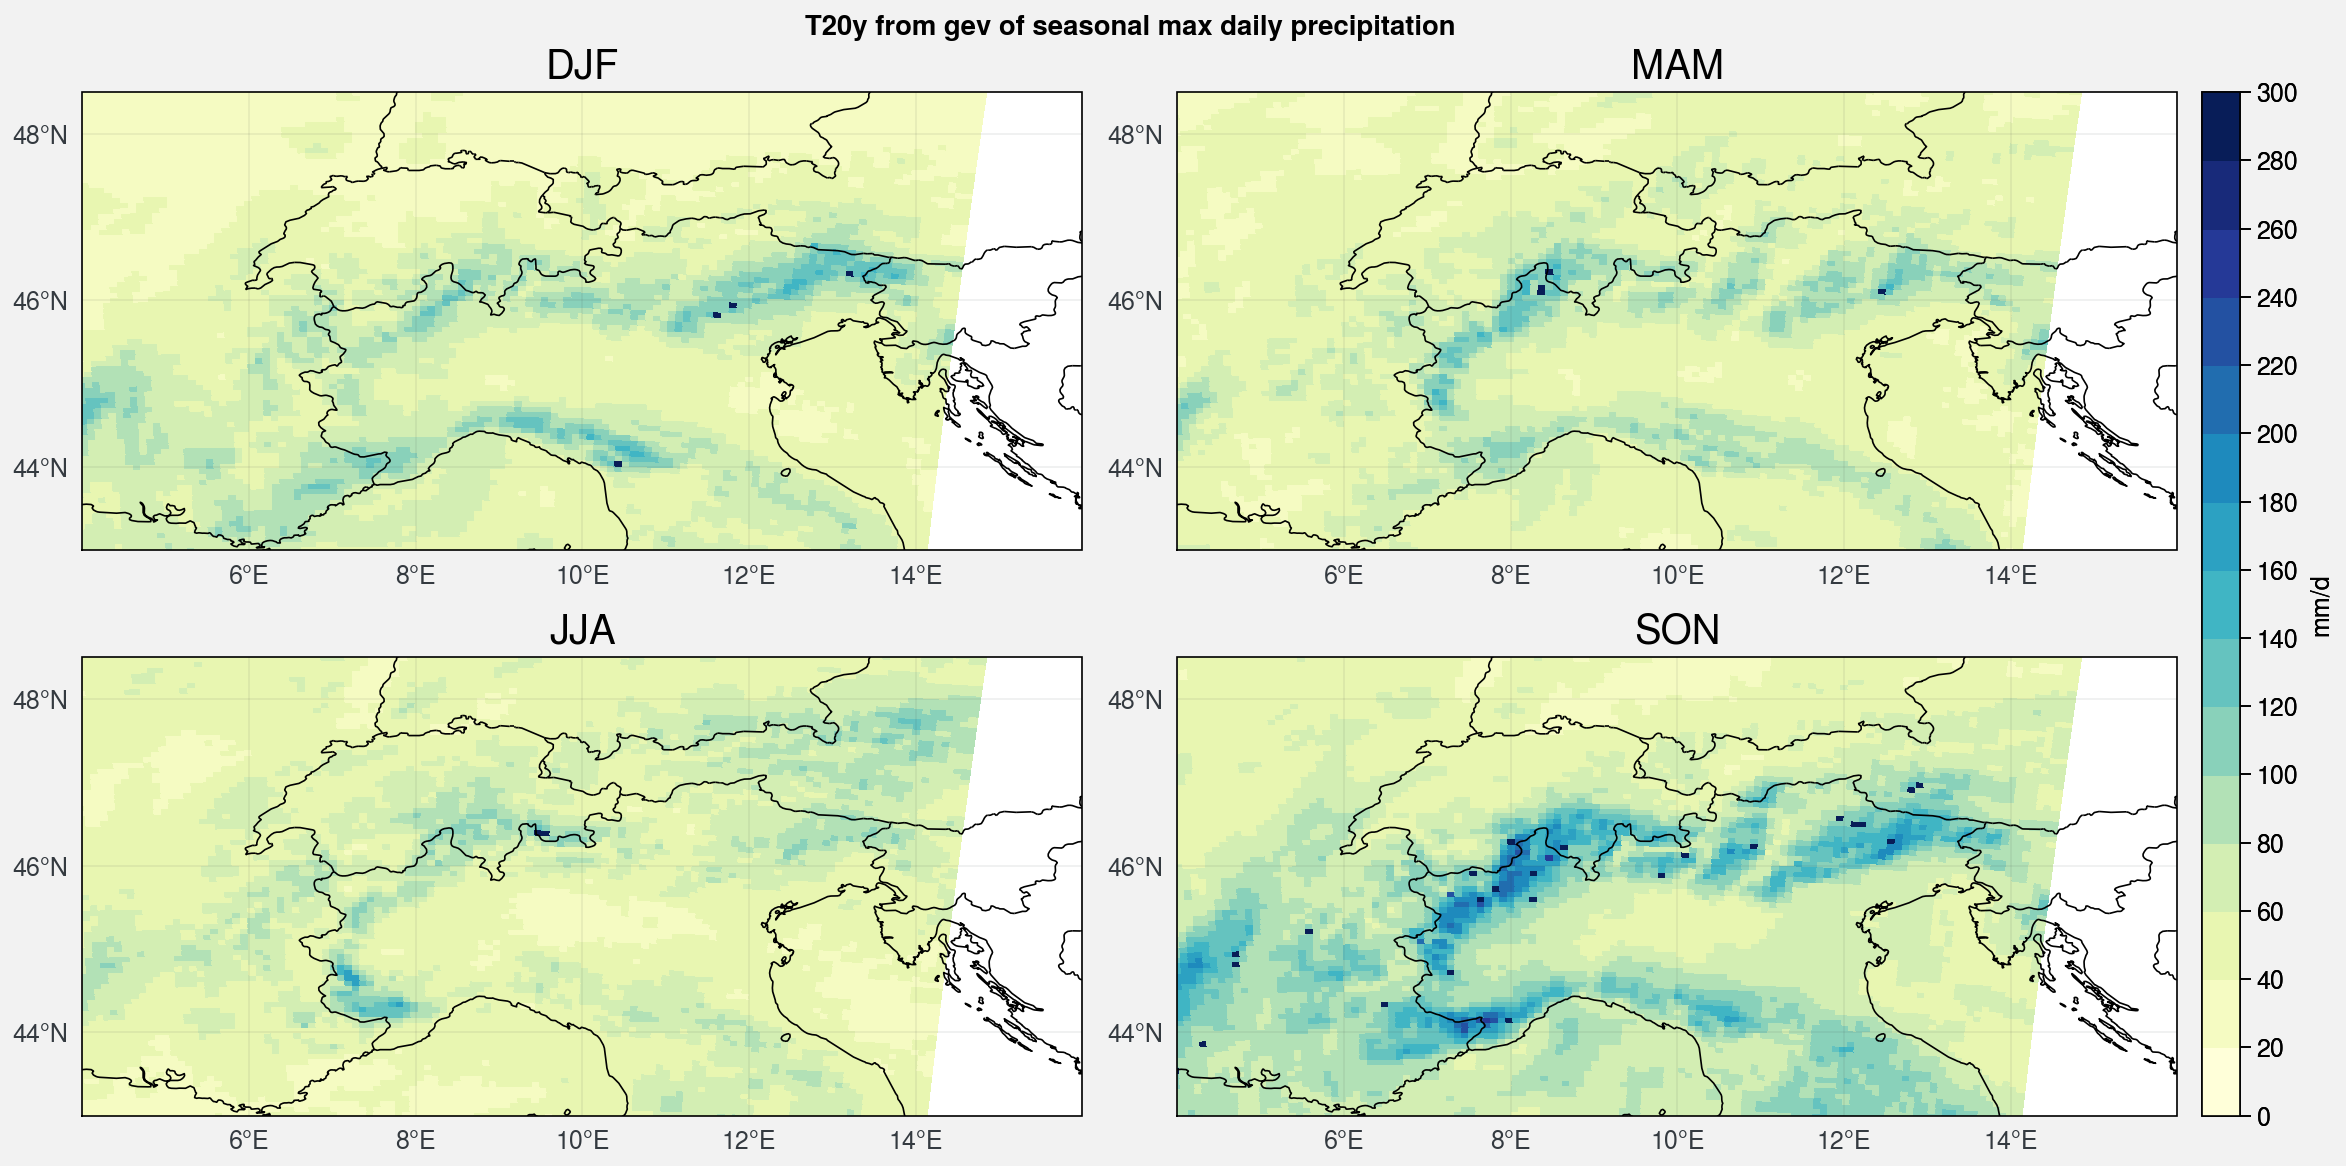

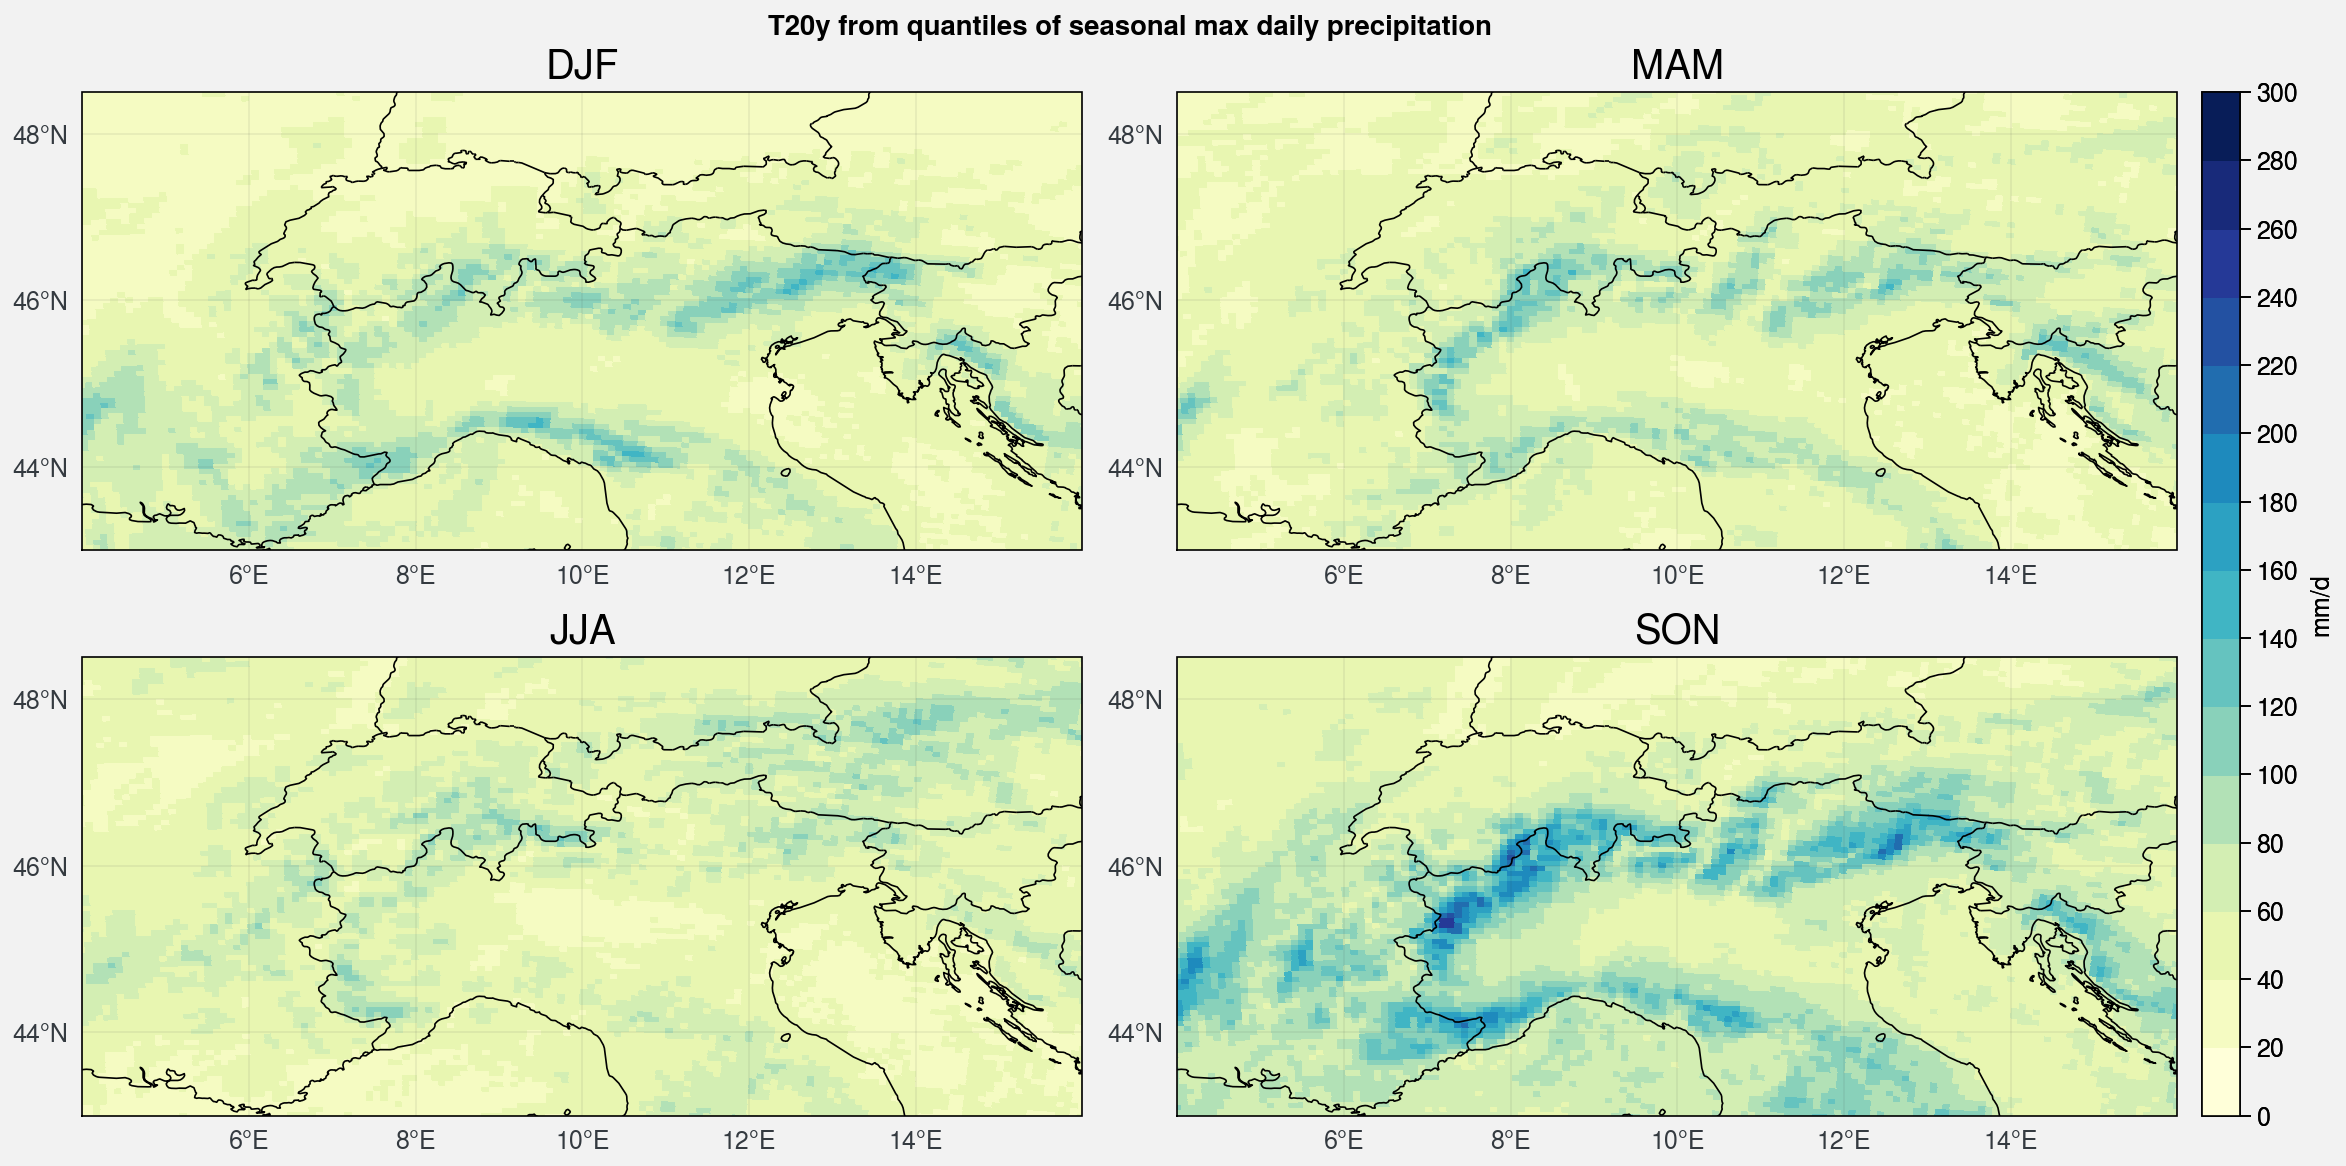

In [8]:
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    data = gev.ppf(0.95, season_gev_map[0,i,:,:], loc=season_gev_map[1,i,:,:], scale=season_gev_map[2,i,:,:])
    m = ax.pcolormesh(ds.LON,ds.LAT,data,levels=np.linspace(0,300,16),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')
axs.format(**normal_format,suptitle="T20y from gev of seasonal max daily precipitation")

f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs): ### 1-0.05*100/np.shape(les_season_max)[0]
    m = ax.pcolormesh(ds.LON,ds.LAT,np.quantile(les_season_max[:,i,:,:],0.95,axis=0),levels=np.linspace(0,300,16),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')
axs.format(**normal_format,suptitle="T20y from quantiles of seasonal max daily precipitation")